In [1]:
#Импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

In [2]:
#Чтение
data = pd.read_csv('data/train_sem.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


### 1. Предварительная проверка данных

In [3]:
#Количество пропусков
data.isna().sum()[data.isna().sum() > 0]

Series([], dtype: int64)

Пропусков нет

In [4]:
#Тип данных
types_df = pd.DataFrame(data.dtypes, columns=['Data Type'])
display(types_df)
types_df.value_counts()

,Data Type
Activity,int64
D1,float64
D2,float64
D3,float64
D4,float64
...,...
D1772,int64
D1773,int64
D1774,int64
D1775,int64


Data Type
float64      942
int64        835
Name: count, dtype: int64

Только числовые типы данных

In [5]:
data = pd.DataFrame(data)

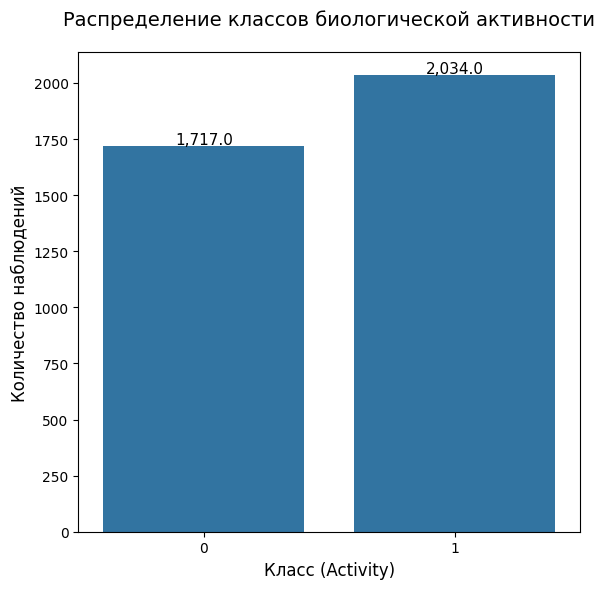

In [6]:
#Создаем график
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=data, x='Activity')

#Добавляем подписи
plt.title('Распределение классов биологической активности', fontsize=14, pad=20)
plt.xlabel('Класс (Activity)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

#Добавляем аннотации с количеством для каждого класса
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=11)
plt.tight_layout()
plt.show()

Выборка визуально сбалансирована

### 2. Визуализация зависимости в данных

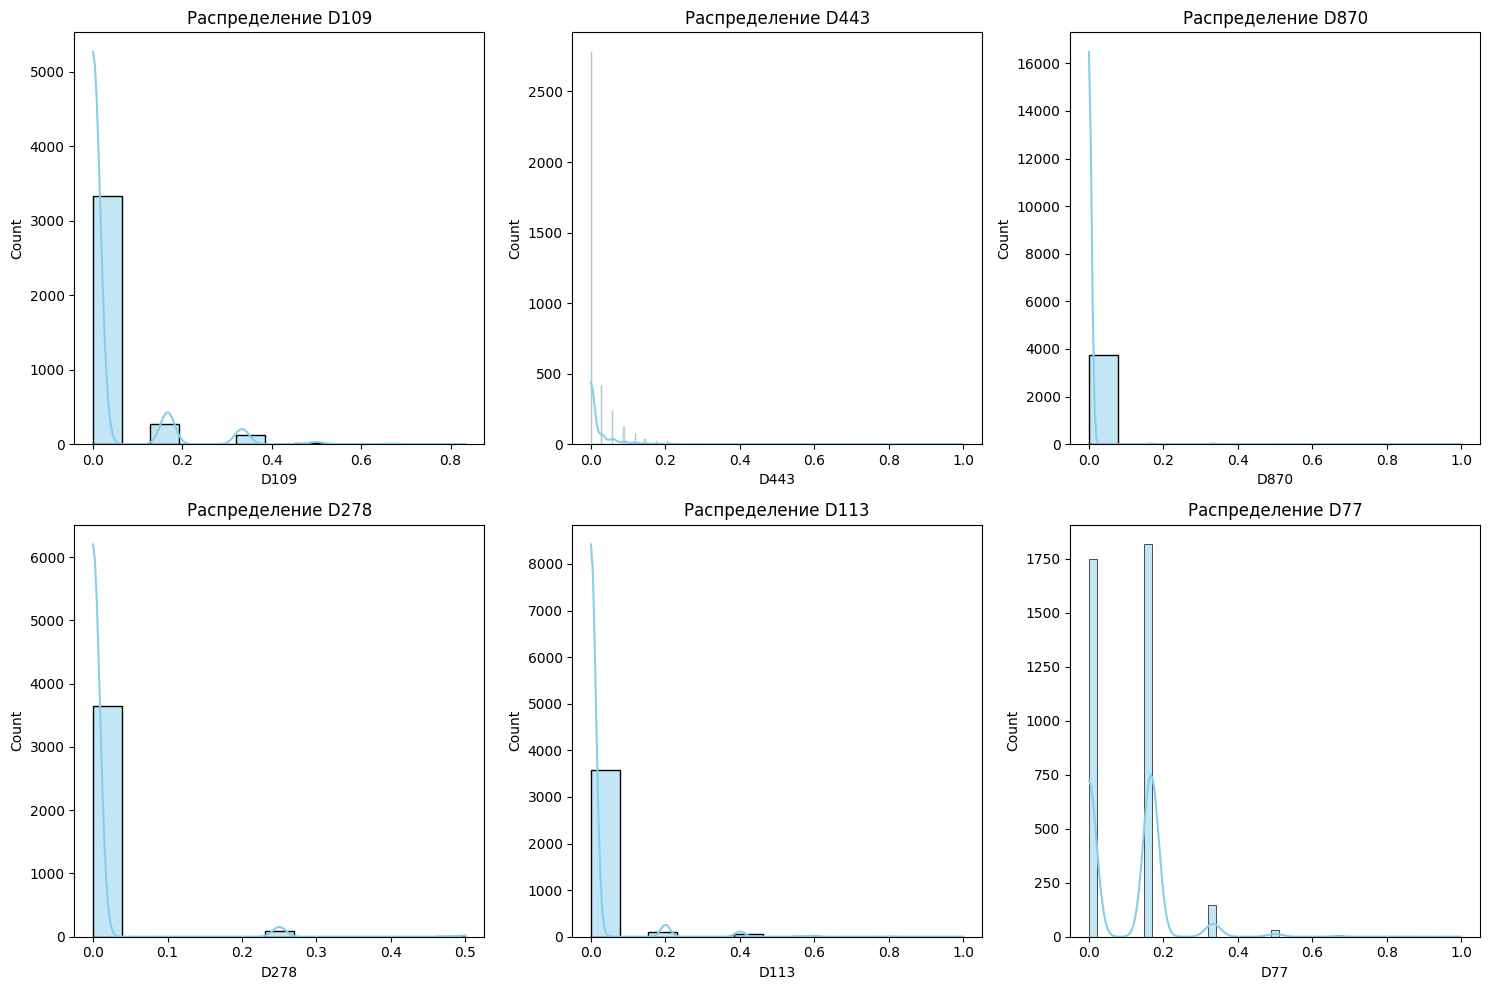

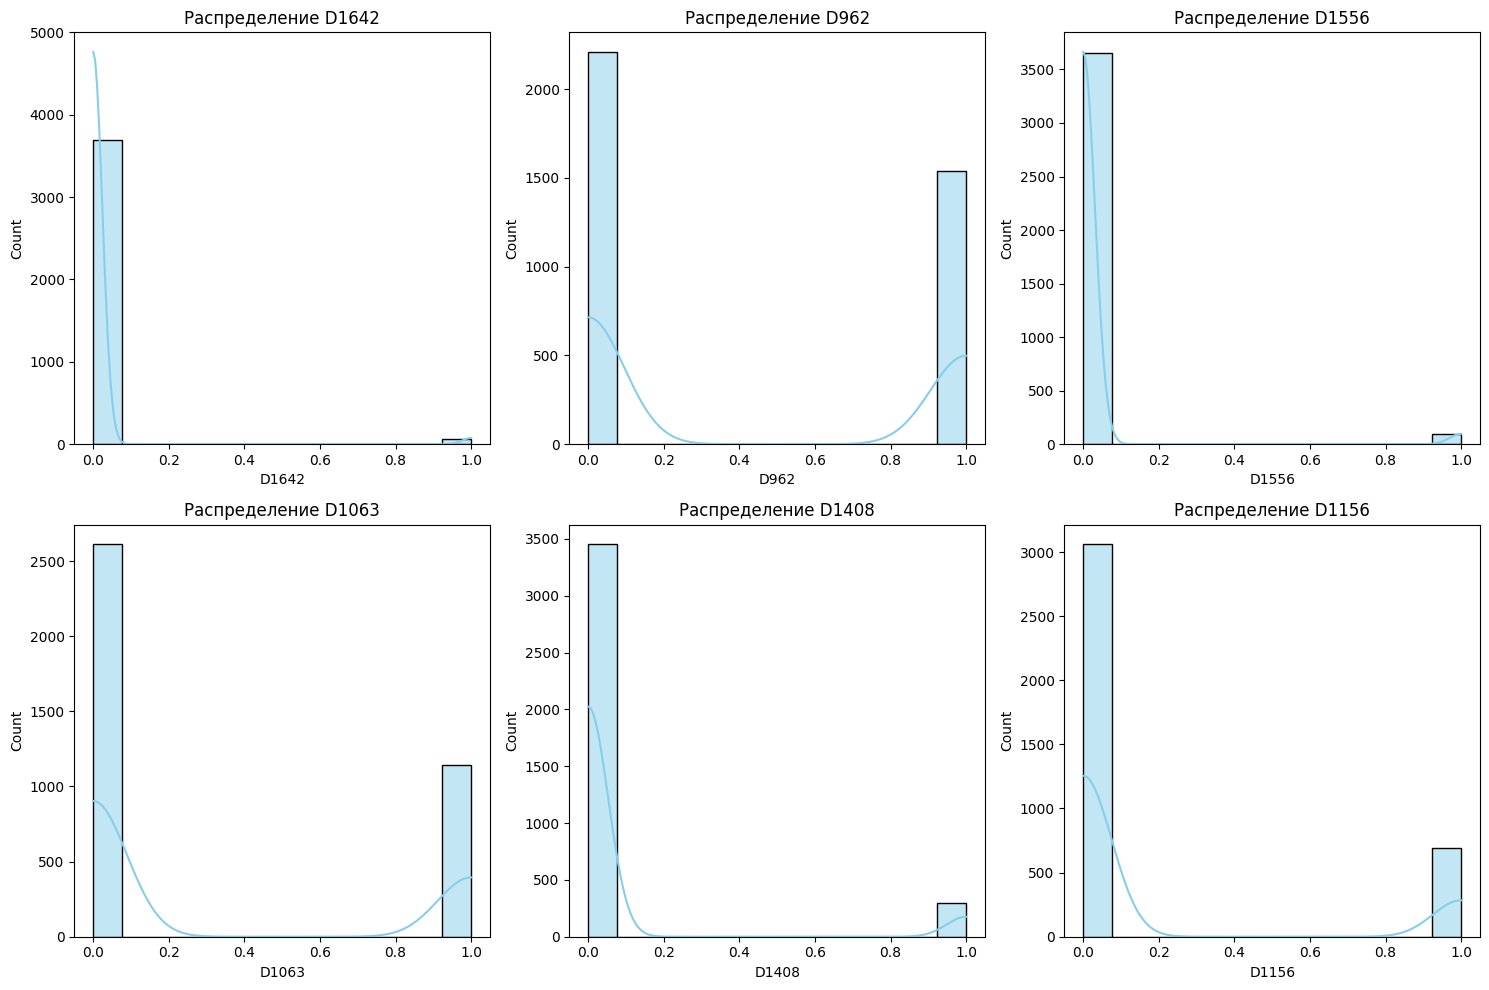

In [7]:
#Выбираем случайные примеры float и int признаков
np.random.seed(42)
float_cols = data.select_dtypes(include='float64').columns.to_list()
int_cols = data.select_dtypes(include='int64').columns.to_list()

#Визуализация 5 случайных float-признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(np.random.choice(float_cols, 6)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

#Визуализация 5 случайных int-признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(np.random.choice(int_cols, 6)):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

Из визуализации видно, что данные распрделены ненормально для обоих типов. С помощью теста Шапиро проверим каждый столбец

Всего проверено столбцов: 1777
С нормальным распределением: 0 (0.0%)
С ненормальным распределением: 1777 (100.0%)


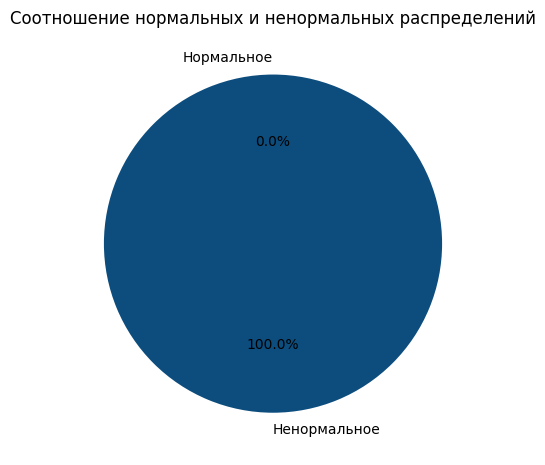

In [8]:
from scipy.stats import shapiro

#Инициализация счетчиков
normal_count = 0
non_normal_count = 0
#Словарь для хранения результатов
results = {
    'Column': [],
    'Statistic': [],
    'p-value': [], 
    'Normal': []
}
#Проверка нормальности для каждого числового столбца
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    #Удаление пропущенных значений
    column_data = data[column].dropna()
    #Проверка нормальности (Shapiro-Wilk test)
    stat, p = shapiro(column_data)
    #Запись результатов
    results['Column'].append(column)
    results['Statistic'].append(stat)
    results['p-value'].append(p)
    is_normal = p > 0.05  #Уровень значимости 5%
    results['Normal'].append(is_normal)
    if is_normal:
        normal_count += 1
    else:
        non_normal_count += 1
#Создание DataFrame с результатами
results_df = pd.DataFrame(results)
#Визуализация результатов
plt.figure(figsize=(12, 6))
#Круговая диаграмма распределения
plt.subplot(1, 2, 1)
plt.pie([normal_count, non_normal_count],
        labels=['Нормальное', 'Ненормальное'],
        colors=["#8ce2fc", "#0c4d7e"],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Соотношение нормальных и ненормальных распределений')
#Вывод статистики
total_columns = len(results_df)
print(f"Всего проверено столбцов: {total_columns}")
print(f"С нормальным распределением: {normal_count} ({normal_count/total_columns:.1%})")
print(f"С ненормальным распределением: {non_normal_count} ({non_normal_count/total_columns:.1%})")

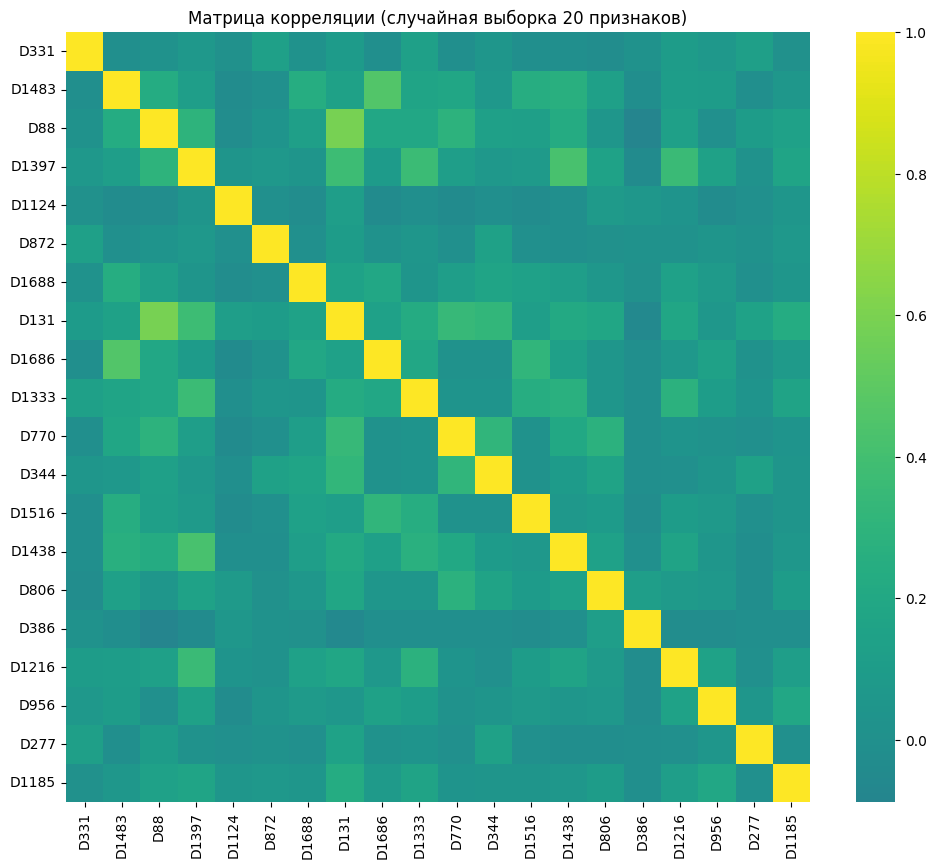

In [9]:
#Выбираем подмножество признаков для корреляции
sample_cols = np.random.choice(data.columns[1:], 20)  #20 случайных признаков
corr_matrix = data[sample_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis', center=0)
plt.title('Матрица корреляции (случайная выборка 20 признаков)')
plt.show()

In [10]:
features = data.drop(columns=['Activity'])
#Порог сильной корреляции
threshold=0.7
#Вычисляем матрицу корреляций
corr_matrix = features.corr().abs()  
#Верхний треугольник матрицы (чтобы избежать дублирования)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))    
#Находим признаки для удаления (корреляция > threshold)
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]  
#Удаляем признаки
reduced_df = features.drop(columns=to_drop)

### 3. Построение модели

#### Линейная регрессия

In [11]:
#Выделение целевого признака
X = reduced_df
y = data['Activity']

In [12]:
#Стратифицированное разделение выборки 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, classification_report

#Обучаем модель
log_reg = LogisticRegression(max_iter=1000,random_state=42)
log_reg.fit(X_train, y_train)
#Получаем вероятности для тестового набора
y_probs = log_reg.predict_proba(X_test)[:, 1] #Вероятности для класса 1

#Вычисляем precision, recall и пороги
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# Вычисляем F1-score для каждого порога
f1_scores = 2 * (precision * recall) / (precision + recall)
#Находим оптимальный порог
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]
print(f"Оптимальный порог: {optimal_threshold:.3f}")
print(f"Максимальный F1-score: {optimal_f1:.3f}")

#Стандартные предсказания (порог 0.5)
y_pred_05 = (y_probs > 0.5).astype(int)
# Оптимальные предсказания
y_pred_optimal = (y_probs > optimal_threshold).astype(int)
#Сравниваем метрики
print("\nСтандартный порог 0.5:")
print(f"F1-score: {f1_score(y_test, y_pred_05):.3f}")
print(f"\nОптимальный порог {optimal_threshold:.3f}:")
print(f"F1-score: {f1_score(y_test, y_pred_optimal):.3f}")

Оптимальный порог: 0.238
Максимальный F1-score: 0.794

Стандартный порог 0.5:
F1-score: 0.777

Оптимальный порог 0.238:
F1-score: 0.792


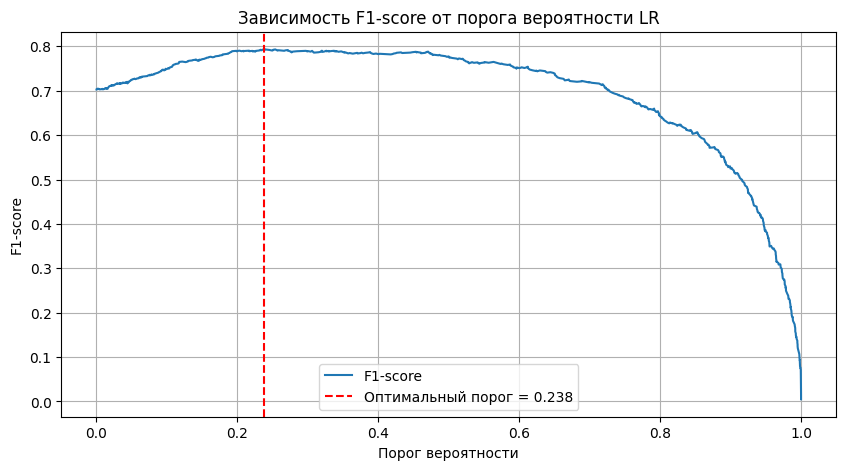

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Оптимальный порог = {optimal_threshold:.3f}')
plt.xlabel('Порог вероятности')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от порога вероятности LR')
plt.legend()
plt.grid()
plt.show()

#### Случайное дерево

In [ ]:
#Обучение базовой модели Random Forest
rf = ensemble.RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
#Оценка базовой модели
y_test_pred_rf = rf.predict(X_test) 
y_train_pred_rf = rf.predict(X_train)
print("Random Forest (базовые параметры):")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_rf):.3f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_rf):.3f}\n")

Random Forest (базовые параметры):
Accuracy: 1.000
F1-score: 0.822



Дерево переобучилось. Нужно оптимизировать параметры

### 4. Оптимизация: линейная регресиия

In [16]:
#Библиотеки методов оптимизации
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

##### GridSearchCV

In [17]:
#Исправленная сетка параметров
param_grid = [{
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': np.logspace(-3, 2, 6),
        'class_weight': [None, 'balanced'],
        'max_iter': np.arange(20,50)}
]
#Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000,random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
#Запуск подбора параметров
print("Начинаем подбор гиперпараметров...")
%time grid_search.fit(X_train, y_train)
#Оценка лучшей модели
best_lr = grid_search.best_estimator_
y_test_pred = best_lr.predict(X_test)
print("\nРезультаты:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.2f}")
print("Лучшие параметры:", grid_search.best_params_)
#Полная метрическая отчетность
print("\nОтчет классификации:")
print(classification_report(y_test, y_test_pred))

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
CPU times: total: 1min 6s
Wall time: 52min 41s

Результаты:
Accuracy: 0.77
F1-score: 0.79
Лучшие параметры: {'C': np.float64(0.1), 'class_weight': None, 'max_iter': np.int64(41), 'penalty': 'l2', 'solver': 'saga'}

Отчет классификации:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       344
           1       0.77      0.82      0.79       407

    accuracy                           0.77       751
   macro avg       0.77      0.76      0.77       751
weighted avg       0.77      0.77      0.77       751



d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
#Обучение на полученных параметрах и вывод метрики f1
#Лучшие параметры из GridSearchCV
best_params = {
    'C': 0.1,
    'class_weight': None,
    'max_iter': 41,
    'penalty': 'l2',
    'solver': 'saga',
    'random_state': 42  #Добавляем для воспроизводимости
}
#Инициализация и обучение модели с лучшими параметрами
best_lr = LogisticRegression(**best_params)
best_lr.fit(X_train, y_train)
#Предсказание на тестовом наборе
y_test_pred = best_lr.predict(X_test)
#Оценка модели
f1 = f1_score(y_test, y_test_pred)
print(f'F1-score на тестовом наборе: {f1:.3f}')
#Полный отчет о классификации
print('\nОтчет о классификации:')
print(classification_report(y_test, y_test_pred))

F1-score на тестовом наборе: 0.795

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       344
           1       0.77      0.82      0.79       407

    accuracy                           0.77       751
   macro avg       0.77      0.76      0.77       751
weighted avg       0.77      0.77      0.77       751



d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Значение f1-метрики улучшилось на 0.003

##### RandomizedSearchCV

In [19]:
#Параметры для RandomizedSearchCV
param_distributions = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': np.arange(20,50),
    'class_weight': [None, 'balanced'],
    'l1_ratio': np.linspace(0, 1, 5)
}
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000,random_state=42),
    param_distributions=param_distributions,
    scoring='f1',
    cv=5,
    n_iter=20,
    random_state=42,
    n_jobs=-1
)
print("Запуск подбора параметров...")
%time random_search_lr.fit(X_train, y_train)
#Оценка качества
y_test_pred = random_search_lr.predict(X_test)
print('\nРезультаты:')
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Лучшие параметры:', random_search_lr.best_params_)

Запуск подбора параметров...


d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1210, in fit
    solver = _check_sol

CPU times: total: 2.48 s
Wall time: 53.2 s

Результаты:
F1-score на тестовом наборе: 0.79
Accuracy: 0.76
Лучшие параметры: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': np.int64(31), 'l1_ratio': np.float64(0.5), 'class_weight': None, 'C': np.float64(1.623776739188721)}


d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
#Обучение на полученных параметрах и вывод метрики f1
#Лучшие параметры из RandomizedSearchCV
best_params = {
    'C': 1.623776739188721,
    'class_weight': None,
    'max_iter': 31,
    'l1_ratio': 0.5,
    'penalty': 'elasticnet',
    'solver': 'saga',
    'random_state': 42  #Добавляем для воспроизводимости
}
#Инициализация и обучение модели с лучшими параметрами
best_lr = LogisticRegression(**best_params)
best_lr.fit(X_train, y_train)
#Предсказание на тестовом наборе
y_test_pred = best_lr.predict(X_test)
#Оценка модели
f1 = f1_score(y_test, y_test_pred)
print(f'F1-score на тестовом наборе: {f1:.3f}')
#Полный отчет о классификации
print('\nОтчет о классификации:')
print(classification_report(y_test, y_test_pred))

F1-score на тестовом наборе: 0.786

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       344
           1       0.77      0.81      0.79       407

    accuracy                           0.76       751
   macro avg       0.76      0.76      0.76       751
weighted avg       0.76      0.76      0.76       751



d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Ухудшение качества на 0.006

In [23]:
from hyperopt import fmin, tpe, Trials, hp
from sklearn.model_selection import cross_val_score

In [26]:
#Определяем пространство гиперпараметров для LogisticRegression
space = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e4)),
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'max_iter': hp.quniform('max_iter', 20, 50, 5),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}
#Функция для оптимизации
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42):
    #Приводим параметры к нужному типу
    params = {
        'C': float(params['C']),
        'penalty': params['penalty'],
        'solver': params['solver'],
        'max_iter': int(params['max_iter']),
        'l1_ratio': float(params['l1_ratio']) if params['penalty'] == 'elasticnet' else None,
        'random_state': random_state
    }
    #Удаляем l1_ratio, если penalty не elasticnet
    if params['penalty'] != 'elasticnet':
        params.pop('l1_ratio', None)
    #Проверяем совместимость параметров
    if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
        return 0.0  #Возвращаем плохой результат для несовместимых комбинаций
    model = LogisticRegression(**params)
    #Используем кросс-валидацию для оценки
    try:
        score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
        return -score  #HyperOpt минимизирует функцию, поэтому берем -F1
    except:
        return 0.0  #Возвращаем плохой результат при ошибках

#Запуск оптимизации
trials = Trials()
best = fmin(
    fn=hyperopt_lr,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.RandomState(42),
    verbose=True
)

#Вывод лучших параметров в читаемом формате
print("\nЛучшие параметры:")
print(f"C: {best['C']}")
print(f"penalty: {['l1', 'l2', 'elasticnet'][best['penalty']]}")
print(f"solver: {['liblinear', 'saga'][best['solver']]}")
print(f"max_iter: {int(best['max_iter'])}")
if best['penalty'] == 2:  #elasticnet
    print(f"l1_ratio: {best['l1_ratio']}")


100%|██████████| 50/50 [03:13<00:00,  3.86s/trial, best loss: -0.7851289038494047]

Лучшие параметры:
C: 0.03593999466604803
penalty: l2
solver: saga
max_iter: 45


In [28]:
#Обучаем модель с лучшими параметрами на всех данных
best_params = {
    'C': float(best['C']),
    'penalty': ['l1', 'l2', 'elasticnet'][best['penalty']],
    'solver': ['liblinear', 'saga'][best['solver']],
    'max_iter': int(best['max_iter']),
    'random_state': 42
}
if best_params['penalty'] == 'elasticnet':
    best_params['l1_ratio'] = float(best['l1_ratio'])
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)
#Оценка на тестовых данных
y_test_pred = final_model.predict(X_test)
print("\nРезультаты на тестовом наборе:")
print(f"F1-score: {metrics.f1_score(y_test, y_test_pred):.4f}")


Результаты на тестовом наборе:
F1-score: 0.7947


d:\Python 3.12.4 amd64\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Улучшение метрики на 0.0027

In [29]:
import optuna

In [32]:
def optuna_lr(trial):
    #Сначала выбираем penalty, так как от него зависят другие параметры
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    #Базовые параметры
    params = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        'penalty': penalty,
        'max_iter': trial.suggest_int('max_iter', 20, 50, step=5),
        'random_state': 42
    }
    #Выбираем solver в зависимости от penalty
    if penalty == 'elasticnet':
        params['solver'] = 'saga'  #Только saga поддерживает elasticnet
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
    elif penalty == 'l1':
        params['solver'] = trial.suggest_categorical('solver_l1', ['liblinear', 'saga'])
    else:  #l2
        params['solver'] = trial.suggest_categorical('solver_l2', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    #Проверка class_weight
    params['class_weight'] = trial.suggest_categorical('class_weight', [None, 'balanced'])
    try:
        model = LogisticRegression(**params)
        score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1', n_jobs=-1).mean()
        return score
    except Exception as e:
        #Возвращаем плохой результат при ошибках
        print(f"Пропускаем комбинацию {params} из-за ошибки: {str(e)}")
        return 0.0
#Создаем исследование
study = optuna.create_study(direction="maximize", study_name="LogisticRegression")
study.optimize(optuna_lr, n_trials=20)
#Выводим результаты
print("\nЛучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"F1-score (кросс-валидация): {study.best_value:.4f}")

[I 2025-08-18 19:50:10,773] A new study created in memory with name: LogisticRegression
[I 2025-08-18 19:50:13,920] Trial 0 finished with value: 0.7512954957071907 and parameters: {'penalty': 'l1', 'C': 0.011563284770303196, 'max_iter': 20, 'solver_l1': 'saga', 'class_weight': None}. Best is trial 0 with value: 0.7512954957071907.
[I 2025-08-18 19:50:15,220] Trial 1 finished with value: 0.7672885962908945 and parameters: {'penalty': 'l2', 'C': 0.004927857726162471, 'max_iter': 40, 'solver_l2': 'saga', 'class_weight': None}. Best is trial 1 with value: 0.7672885962908945.
[I 2025-08-18 19:50:15,947] Trial 2 finished with value: 0.7493633815029225 and parameters: {'penalty': 'l2', 'C': 4.400748138836339, 'max_iter': 50, 'solver_l2': 'liblinear', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7672885962908945.
[I 2025-08-18 19:50:17,087] Trial 3 finished with value: 0.7683522768081592 and parameters: {'penalty': 'l1', 'C': 4178.919497902174, 'max_iter': 20, 'solver_l1': 'saga'


Лучшие параметры:
penalty: elasticnet
C: 0.07703323868054815
max_iter: 40
l1_ratio: 0.22721180417609593
class_weight: None
F1-score (кросс-валидация): 0.7756


### 5. Оптимизация: случайное дерево